In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## read pascal-voc

In [2]:
import os
import glob
from tool.pascal_voc import read_pascal_voc
currentpath = os.path.abspath('.')
xmlfiles = glob.glob(os.path.join(currentpath,'data/*.xml'))

ImportError: No module named 'dicttoxml'

In [ ]:
ann = {}
for file in xmlfiles:
    gtboxes , _ = read_pascal_voc(file)
    imgname = os.path.basename(file)
    ann[imgname] = gtboxes

##   画框保存为png

In [9]:
import cv2

In [86]:
all_boxes = []
for filename,gtboxes in ann.items():
    filename = filename.split('.')[0]
    imgfile = os.path.join(currentpath,'data',filename+'.JPG')
    img = cv2.imread(imgfile)
    for box in gtboxes:
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        all_boxes.append([x1,y1,x2,y2])
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),2,cv2.LINE_AA)
    cv2.imwrite(os.path.join(currentpath,'data',filename+'.png'),img)

In [244]:
all_boxes = np.array(all_boxes)
boxes_w = np.sort(all_boxes[:,2] - all_boxes[:,0])
boxes_h = np.sort(all_boxes[:,3] - all_boxes[:,1])
print(boxes_w)
print(boxes_h)

[  23   24   25 ...  964 1027 1188]
[  25   25   26 ...  874 1006 1217]


In [98]:
all_boxes

array([[   1, 1437,  513, 1909],
       [ 848,  795,  996,  925],
       [1539,  761, 1638,  859],
       ...,
       [ 604, 1304,  934, 1689],
       [ 519, 1663,  607, 1751],
       [ 507, 1560,  631, 1669]])

## 转换为训练格式

In [14]:
labelfile = os.path.join(currentpath,'data','train.txt')

In [15]:
### 统计类别 
classid=[]
for filename,gtboxes in ann.items():
    classid += list(gtboxes[:,4])
classid = set(classid)
class_to_id = {key:id for id,key in enumerate(classid)}

In [16]:
class_to_id

{'上皮细胞': 4, '单孢子': 1, '滴虫': 0, '白细胞': 2, '芽生孢子': 3}

In [17]:
with open(labelfile,'w',encoding='utf-8') as f:
    for filename,gtboxes in ann.items():
        filename = filename.split('.')[0]
        imgfile = os.path.join(currentpath,'data',filename+'.JPG')
        str_label = imgfile
        for box in gtboxes:
            str_label = str_label + ' '+ ','.join(box[:4]) + ',' + str(class_to_id[box[4]])
        f.writelines(str_label+'\n')
    

## 确定achor box的大小

In [15]:
from kmeans import YOLO_Kmeans
import matplotlib.pyplot as plt
import numpy as np 

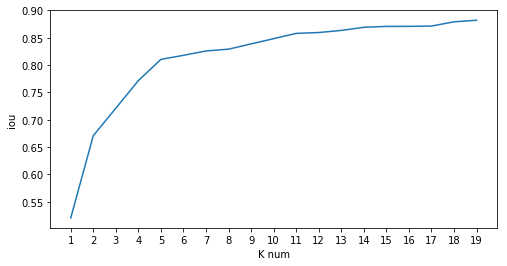

In [23]:
iou_y = []
cluster_x=[]
filename = "data/train.txt"

for cluster_number in range(1,20):
    kmeans = YOLO_Kmeans(cluster_number, filename)
    _,avg,all_boxes  = kmeans.txt2clusters()
    iou_y.append(avg)
    cluster_x.append(cluster_number)
    
plt.figure(figsize=(8,4)) #
plt.xlabel("K num") 
plt.ylabel("iou")  
my_x_ticks = np.arange(0,20, 1)
plt.xticks(my_x_ticks)
plt.plot(cluster_x,iou_y)
plt.show()

In [24]:
kmeans = YOLO_Kmeans(6, filename)
anchor,avg,all_boxes  = kmeans.txt2clusters()

[[ 56  56]
 [ 85  84]
 [104 106]
 [129 124]
 [163 167]
 [461 441]]


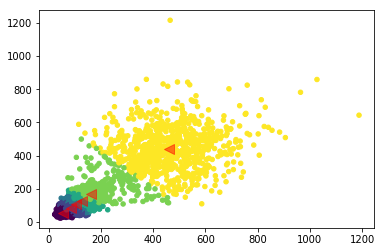

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)  # 将数据聚类
kmeans.cluster_centers_ = anchor
y_kmeans = kmeans.predict(all_boxes)  # 预测

plt.scatter(all_boxes[:, 0], all_boxes[:, 1],c=y_kmeans ,s=20, cmap='viridis')  # c是颜色，s是大小
centers = kmeans.cluster_centers_  # 聚类的中心
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='<',alpha=0.5)  
print(centers)
plt.show()  # 展示

In [10]:
filename = "data/train.txt"
cluster_number = 9
kmeans = YOLO_Kmeans(cluster_number, filename)

anchor,avg,all_boxes  = kmeans.txt2clusters()
print(anchor,avg)

[[ 49  50]
 [ 63  62]
 [ 83  87]
 [ 93 112]
 [106 104]
 [115  77]
 [129 125]
 [164 168]
 [461 441]] 0.847988033128161


In [82]:
w,h = (3072,2084)

In [105]:
3072/1056

2.909090909090909

In [112]:
928/32

29.0

## 随机剪切

In [133]:
input_shape=(928,928)

In [230]:
with open(filename) as f:
    lines = f.readlines()

In [348]:
from yolo3.utils import get_random_data

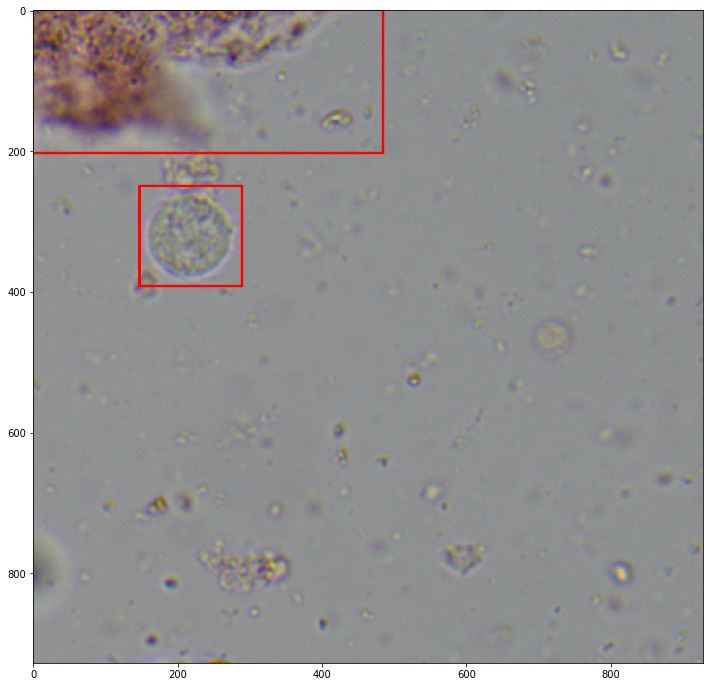

In [357]:
img,boxes = get_random_data(lines[1],input_shape)
#print(lines[1],boxes)
img = img[:,:,::-1] * 255
img = img.astype(np.uint8)
for box in boxes:
    cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,0,255),2,cv2.LINE_AA)
img = img[:,:,::-1]
plt.rcParams["figure.figsize"] = (12,12)
plt.imshow(img,aspect='auto')

In [216]:
img.shape

(928, 928, 3)

In [181]:
cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,0,255),5,cv2.LINE_AA)

TypeError: Layout of the output array img is incompatible with cv::Mat (step[ndims-1] != elemsize or step[1] != elemsize*nchannels)

ValueError: invalid literal for int() with base 10: '222s'

In [283]:
a = np.array([1.0,1.2])

In [286]:
b = a.astype(np.int32)

In [3]:
import collections

In [10]:
from dicttoxml import dicttoxml
from collections import OrderedDict
def tree(): return collections.defaultdict(tree)
class Node(object):
    def __init__(self, name):
        self._name = name

    def __str__(self):
        return self._name
xml = tree()

xml['annotation'][Node('oject')] = 'o1'
xml['annotation'][Node('oject')] = 'o2'
xml['annotation']['folder'] = '1'
xml['annotation']['filename'] = '2'
xml['annotation']['path'] = '1'
xml['annotation']['source']['dataset'] = 'Unknown'
request_xml = dicttoxml(xml, attr_type=False, root=False)
print(request_xml)

b'<annotation><oject>o1</oject><folder>1</folder><oject>o2</oject><source><dataset>Unknown</dataset></source><filename>2</filename><path>1</path></annotation>'
